In [269]:
!python -V

Python 3.9.12


In [270]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge



from sklearn.metrics import mean_squared_error


/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

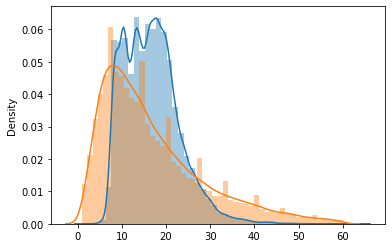

In [271]:
sns.distplot(y_pred, label = 'predictino')
sns.distplot(y_train, label = 'actual')

In [272]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td:td.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    categorical = ['PULocationID','DOLocationID']
    numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)
    return df

In [273]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [274]:
len(df_train), len(df_val)

(73908, 61921)

In [275]:
df_train['PU_DO']= df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO']= df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [276]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [277]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [278]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

FileNotFoundError: [Errno 2] No such file or directory: 'models/lin_reg.bin'

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)